In [38]:
import numpy as np 
import cmocean
from netCDF4 import Dataset
import glob
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import datetime 
from datetime import date 
import mpl_toolkits.basemap as bm
import matplotlib.animation as animation
import numpy.ma as ma
import matplotlib.cm as cm
from matplotlib.patches import Polygon
from scipy import signal, stats
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings; warnings.simplefilter('ignore')

from functions import load_ice, trend, find_trends, plot_cartopy, decomp


# Concentration

In [39]:
path = '/extra-space1/data/tikoralukupload/cis-weekly/nc/'
region = 'HB'

lon, lat, juld, CT = load_ice(path,region,'E_CT')

In [40]:
tic=time.time()
print(tic)

ybar_monthly, ytrend_monthly, dtrend_95_monthly = decomp(lon,lat,juld,CT,'monthly')

toc = time.time()
print(toc-tic)

1622855172.6886494
2015.0178065299988
2015.0488557815552


In [20]:
def plot_cartopy(ax):
    '''
    Set up the cartopy map with projection rotated so that Labrador coast is vertical. Input is the ax handle. 
    '''
    #Declare the land and ocean parameters
    LAND_highres = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
    edgecolor='black',
    facecolor=('silver'),
    linewidth=1)
    OCEAN_highres = cartopy.feature.NaturalEarthFeature('physical', 'ocean', '10m',
    facecolor='dimgrey')

    #Declare the lat and lon boundaries for the map and data
    domain = [99, 99, -99, -99]
    domain[0] = np.min(lat) # South
    domain[1] = np.min(lon) # West
    domain[2] = np.max(lat) # North
    domain[3] = np.max(lon) # East
    #     domain = list(np.array(domain) + np.array([+1, +6, 0, -4]))
    domain = [53.58105923668295, -61.30979545701268, 61.589404038199575, -56.47452933956656]
    # domain = [55, -61.30979545701268, 59, -61]

    aoi_map = [domain[0], domain[2], domain[1], domain[3]]
    # Rotation for vertical coast
    rot = ccrs.RotatedPole(pole_latitude=55,pole_longitude=150)

#     # Plot results
#     transform = rot.transform_points(rot,lon,lat)
#     x_n = transform[...,0]
#     y_n = transform[...,1]

    ax.add_feature(LAND_highres,zorder=2)
    ax.add_feature(OCEAN_highres,zorder=3)
    ax.set_extent([aoi_map[2], aoi_map[3], aoi_map[0], aoi_map[1]])
    ax.coastlines(resolution='10m',linewidth=0.35,zorder=3)
    

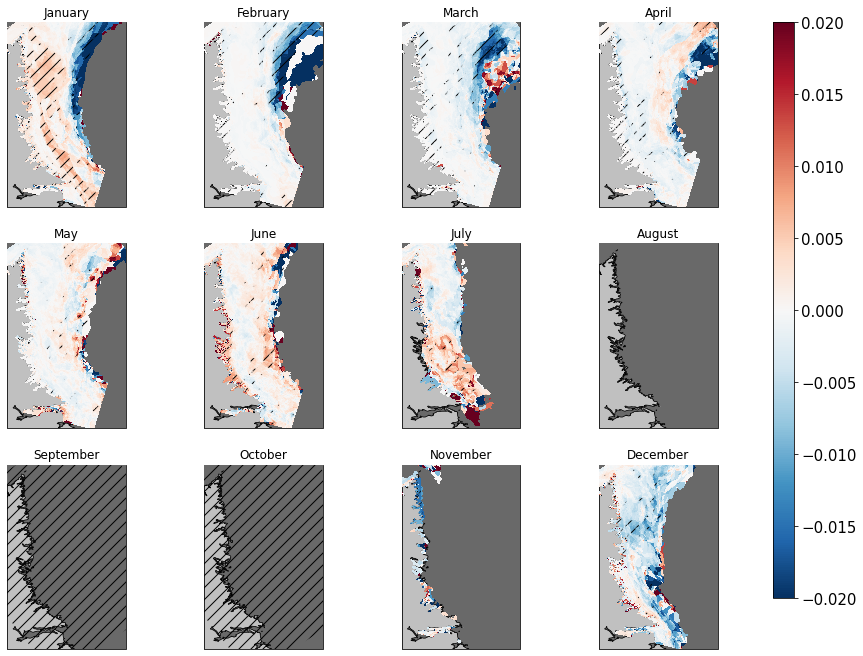

In [32]:
# Map monthly trends 

fig = plt.figure(figsize=(15,10))
rot = ccrs.RotatedPole(pole_latitude=55,pole_longitude=150)

transform = rot.transform_points(rot,lon,lat)
x_n = transform[...,0]
y_n = transform[...,1]


months_str = ['January','February','March','April','May','June','July',
             'August','September','October','November','December']

for i in range(0,12):
    ax = fig.add_subplot(3,4,i+1, projection=rot)
    plot_cartopy(ax)
    im = plt.pcolormesh(x_n,y_n,ytrend_monthly[i,:,:],cmap='RdBu_r',vmin=-0.02,vmax=0.02, transform=ccrs.PlateCarree(),zorder=4) 
    plt.title(months_str[i])
    
    sign = np.sign(ytrend_monthly[i,:,:])
    hatched=np.zeros(np.shape(ytrend_monthly[i,:,:]))
    for (x,y), value in np.ndenumerate(sign):
        if np.sign(ytrend_monthly[i,x,y] + dtrend_95_monthly[i,x,y]) != value or np.sign(ytrend_monthly[i,x,y] - dtrend_95_monthly[i,x,y]) != value:
            # Create array for hatching. Ones represent non-significant values
            hatched[x,y]=1
    plt.contourf(x_n,y_n,hatched,levels=1, hatches=['//', ''],  alpha=0., transform=ccrs.PlateCarree(),zorder=4)
    
fig.subplots_adjust(bottom=0.03, top=0.9, left=0.1, right=0.8,
                    wspace=0.2, hspace=0.2)
cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)
cbar.ax.tick_params(labelsize=15)

# Thickness

In [ ]:
lon, lat, juld, h_A = load_ice(path,region,'E_SA')

In [105]:
tic=time.time()
print(tic)

hbar_monthly, htrend_monthly, h_dtrend_95_monthly = decomp(lon,lat,juld,h_A,'monthly')

toc = time.time()
print(toc-tic)

1609888656.8938172
295.20692229270935


### Thickness

In [17]:
tic=time.time()
print(tic)

hbarEC, htrendEC, hdtrend_95EC = find_trends(path,region,'monthly',lon,lat,juld,h_A)

toc = time.time()
print(toc-tic)

1610333087.8745859
658.6668412685394


### Subtract trendline value (y) rather than slope from the data. This will ensure mean of anomolies are 0.

In [374]:
n = np.shape(lon)[0]
m = np.shape(lon)[1]
ytrend = np.zeros((n,m))
slope = np.zeros((n,m))
intercept = np.zeros((n,m))

tic = time.time()

for i in range(n):
    for j in range(m):
        idx = np.isfinite(juld) & np.isfinite(CT[:,i,j])
        if np.any(idx) == True:
            # Get trendline equation
            s,b = np.polyfit(juld[idx],CT[idx,i,j],1)
            slope[i,j] = s
            intercept[i,j] = b
            
toc = time.time()
print(toc-tic)

193.5988528728485


In [377]:
n = np.shape(slope)[0]
m = np.shape(slope)[1]
k = len(juld)
anom = np.zeros((k,n,m))

for i in range(n):
    for j in range(m):
        anom[:,i,j] = CT[:,i,j] - (juld*slope[i,j] + intercept[i,j]) 

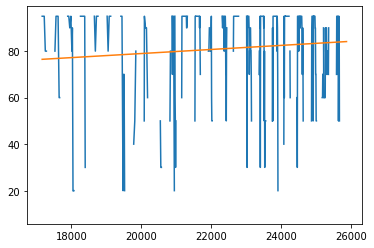

In [376]:
plt.figure()
plt.plot(juld, CT[:,110,110])
plt.plot(juld, slope[110,110]*juld + intercept[110,110])

**Standard deviation of anomolies**

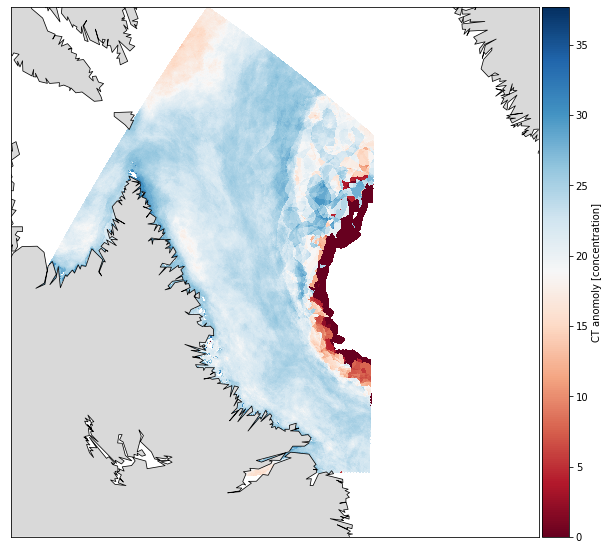

In [412]:
fig = plt.figure(figsize=(10,10))
# %matplotlib inline
domain = [99, 99, -99, -99]
domain[0] = np.min(lat) # South
domain[2] = np.max(lat) # North
domain[1] = np.min(lon) # West
domain[3] = np.max(lon) # East
# domain = list(np.array(domain) + np.array([+6, +3, -5, -9]))
proj = bm.Basemap(projection='merc', llcrnrlat=domain[0], llcrnrlon=domain[1], urcrnrlat=domain[2], urcrnrlon=domain[3], resolution='l')
lonproj, latproj = proj(lon, lat)
proj.fillcontinents(color='0.85', lake_color=None, ax=None, zorder=None, alpha=None)
proj.drawcoastlines(color='k', linewidth=0.75)

# im = plt.pcolormesh(lonproj,latproj,np.nanmean(anom,axis=0),cmap='RdBu',vmin=-1,vmax=1)

# std of anomolies
im = plt.pcolormesh(lonproj,latproj,np.nanstd(anom, axis=0),cmap='RdBu')


# # plot hatching
# plt.title('Thickness mean')
ax = plt.gca()
# # Fix colorbar axis
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('CT anomoly [concentration]')

Examine low anomoly regions. Most likely due to small amount of data. Why are there high(er) anomolies by the coast? 

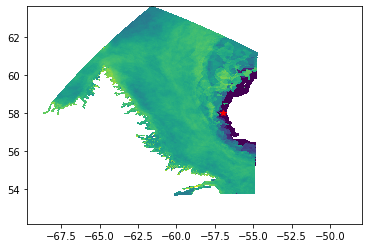

In [401]:
plt.figure()
plt.pcolormesh(lon,lat,np.nanstd(anom,axis=0))
plt.plot(lon[loc], lat[loc],'r*')

In [400]:
lon0 = -57
lat0 = 58
d = np.sqrt((lon-lon0)**2 + (lat-lat0)**2) 
# index for lon and lat of lon0 and lat0 
loc = np.unravel_index(np.argmin(d, axis=None), d.shape)
print(loc)

(345, 560)


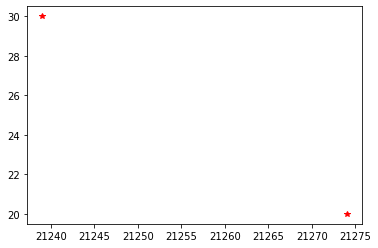

In [410]:
plt.figure()
plt.plot(juld,CT[:,345,560],'r*')
# plt.plot(juld,CT[:,0,100])

# Monthly anomolies

Now plot monthly anomoly standard deviations to make more sense of it

Try for 1 month

In [667]:
# Convert dates
d0ord = date(1950,1,1).toordinal()
dt_ordinal = d0ord + juld
dates = [date.fromordinal(dt_ordinal[tt]) for tt in range(len(juld))]
months = [dates[tt].month for tt in range(len(juld))]
months_unique = np.unique(months)

n = np.shape(lon)[0]
m = np.shape(lon)[1]
slope = np.zeros((n,m))
intercept = np.zeros((n,m))

tic = time.time()

inds = np.array(months)==1
for i in range(n):
    for j in range(m):
        idx = np.isfinite(juld[inds]) & np.isfinite(CT[inds,i,j])
        if np.any(idx) == True:
            s,b = np.polyfit(juld[inds],CT[inds,i,j],1)
            slope[i,j] = s
            intercept[i,j] = b
            
toc = time.time()
print(toc-tic)

185.71662831306458


In [695]:
n = np.shape(slope)[1]
m = np.shape(slope)[2]
inds = np.array(months)==2

k = len(juld[inds])
anom = np.zeros((k,n,m))

for i in range(n):
    for j in range(m):
        anom[:,i,j] = CT[inds,i,j] - (juld[inds]*slope[1,i,j] + intercept[1,i,j]) 

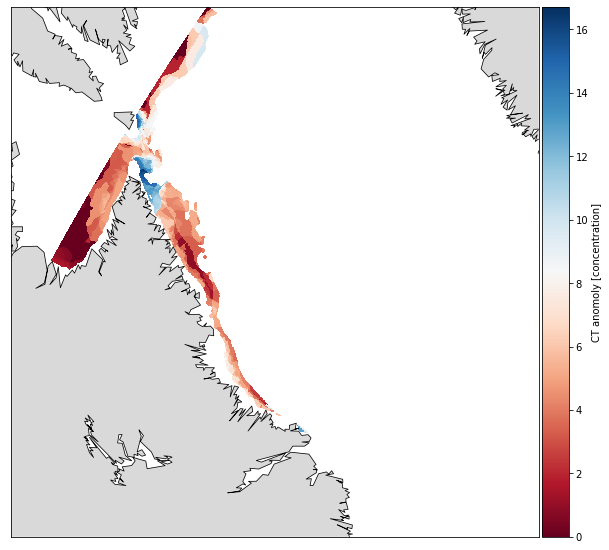

In [696]:
fig = plt.figure(figsize=(10,10))
# %matplotlib inline
domain = [99, 99, -99, -99]
domain[0] = np.min(lat) # South
domain[2] = np.max(lat) # North
domain[1] = np.min(lon) # West
domain[3] = np.max(lon) # East
# domain = list(np.array(domain) + np.array([+6, +3, -5, -9]))
proj = bm.Basemap(projection='merc', llcrnrlat=domain[0], llcrnrlon=domain[1], urcrnrlat=domain[2], urcrnrlon=domain[3], resolution='l')
lonproj, latproj = proj(lon, lat)
proj.fillcontinents(color='0.85', lake_color=None, ax=None, zorder=None, alpha=None)
proj.drawcoastlines(color='k', linewidth=0.75)

# im = plt.pcolormesh(lonproj,latproj,np.nanmean(anom,axis=0),cmap='RdBu',vmin=-1,vmax=1)

# std of anomolies
im = plt.pcolormesh(lonproj,latproj,np.nanstd(anom, axis=0),cmap='RdBu')


# # plot hatching
# plt.title('Thickness mean')
ax = plt.gca()
# # Fix colorbar axis
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('CT anomoly [concentration]')

# Monthly anomolies - good

In [670]:
# Convert dates
d0ord = date(1950,1,1).toordinal()
dt_ordinal = d0ord + juld
dates = [date.fromordinal(dt_ordinal[tt]) for tt in range(len(juld))]
months = [dates[tt].month for tt in range(len(juld))]
months_unique = np.unique(months)

n = np.shape(lon)[0]
m = np.shape(lon)[1]
slope = np.zeros((len(months_unique),n,m))
intercept = np.zeros((len(months_unique),n,m))

tic = time.time()

for month in months_unique:
    inds = np.array(months)==month
    for i in range(n):
        for j in range(m):
            idx = np.isfinite(juld[inds]) & np.isfinite(CT[inds,i,j])
            if np.any(idx) == True:
                s,b = np.polyfit(juld[inds],CT[inds,i,j],1)
                slope[month-1,i,j] = s
                intercept[month-1,i,j] = b
            
toc = time.time()
print(toc-tic)

1
2
3
4
5
6
7
8
9
10
11
12
1984.512789964676


### Standard deviation of anomolies

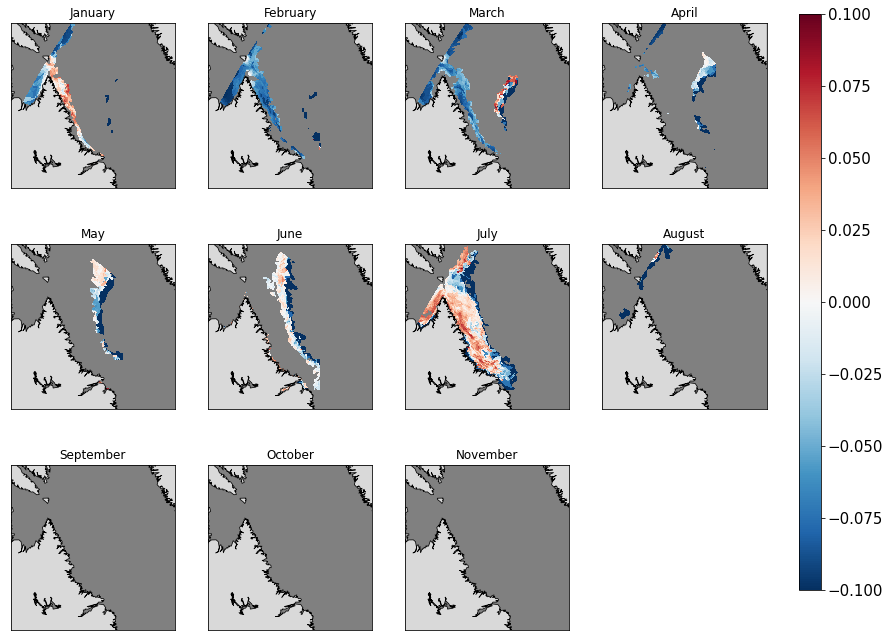

In [700]:
n = np.shape(slope)[1]
m = np.shape(slope)[2]

months_str = ['January','February','March','April','May','June','July',
             'August','September','October','November','December']

fig = plt.figure(figsize=(15,10))

anom_monthly = []

for p in range(1,13):
    inds = np.array(months)==p
    k = len(juld[inds])
    anom = np.zeros((k,n,m))
        
    for i in range(n):
       for j in range(m):
            anom[:,i,j] = CT[inds,i,j] - (juld[inds]*slope[p,i,j] + intercept[p,i,j])
            
    anom_monthly.append(anom)
    
    plt.subplot(3,4,p,facecolor='grey')
    proj.fillcontinents(color='0.85', lake_color=None, ax=None, zorder=None, alpha=None)
    proj.drawcoastlines(color='k', linewidth=0.75)
    im = plt.pcolormesh(lonproj,latproj,np.nanstd(anom_monthly[p-1],axis=0),cmap='RdBu_r')   
    plt.title(months_str[p-1])

fig.subplots_adjust(bottom=0.03, top=0.9, left=0.1, right=0.8,
                    wspace=0.2, hspace=0.2)
cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)
cbar.ax.tick_params(labelsize=15)

In [ ]:
anom_monthly